In [7]:
### We want to run PCA on the raw STL10 images, and on the corresponding SimCLR representations of those images
### We expect that for the raw images, more PCs will be required to explain a high proportion of the variance
### We expect that for the SimCLR representations, we will see a high proportion of the variance explained by fewer PCs

In [8]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    # $pip install --quiet pytorch-lightning>=1.4
    import subprocess
    subprocess.check_call(["pip", "install", "--quiet", "pytorch-lightning>=1.4"])
    import pytorch_lightning as pl

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision
from torchvision.datasets import STL10

try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    # $pip install --quiet pytorch-lightning>=1.4
    import subprocess
    subprocess.check_call(["pip", "install", "--quiet", "pytorch-lightning>=1.4"])
    import pytorch_lightning as pl

DATASET_PATH = "../data"
MODEL_CHECKPOINT_PATH = "../models/tutorial17/SimCLR.ckpt"

/var/folders/_c/21m3vmjd7c1_75f4nxmg1k480000gn/T/ipykernel_32832/1944442167.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cpu
Number of workers: 10


<Figure size 640x480 with 0 Axes>

In [9]:
def prepare_features_stl10_images(dataset):
    """
    PCA operates on a 2D matrix, where each row is a data sample (an image) and each column is a feature (pixel value)
    First, flatten each image into a vector
    Then stack all image vectors into a matrix X of shape N x D, where N is num images, and D is num pixels per image (features)
    D = the number of features per vector = 96 x 96 pixels x 3 (RGB channels) = 27648 features per image
    N = 5000 images

    STL10 image:             (96, 96, 3)
    Tensor:                  (3, 96, 96)
    Data stack (all images): (5000, 3, 96, 96)
    Matrix X (flattened):    (5000, 27648)
    """

    # Load all 5000 images as a single batch into memory
    # DataLoader is used to load data in batches, but we want to load all data at once
    # iter(data_loader) converts it to an iterator
    # next(...) gets the first (and only) batch from the iterator
    data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    images, labels = next(iter(data_loader))

    # Reshapes (flattens) each image in the batch into a 1D vector 
    # images.view(num_images, -1) -> "Make the first dimension num_images and calculate whatever is left for the second dimension."
    # (num_images, channels, height, width) -> (num_images, num_pixels)
    num_images, channels, height, width = images.shape
    flattened_images = images.view(num_images, -1)

    return data.TensorDataset(flattened_images, labels)

class SimCLR(pl.LightningModule):
    """
    @todo I adapted these from the SimCLR class from the 001_test_sim_clr.ipynb tutorial notebook
    There it is used for training and feature extraction
    We can remove the training logic - all we need is the pretrained base encoder
    """
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        """
        PyTorch Lightning's load_from_checkpoint (called in cells below) handles hyperparameter loading automatically,
        just grabs them from the checkpoint itself so we don't have to pass them when we initialise SimCLR class, or call 
        load_from_checkpoint
        """
        super().__init__()
        
        self.save_hyperparameters() # 
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        
        # We don't actually need this as we're just extracting features (from the base encoder)
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

@torch.no_grad()
def prepare_features_simclr_representations(model, dataset):
    """
    This removes the projection head of the SimCLR model and uses the base encoder to extract feature representations 
    for each image in the (in this case STL10) dataset.

    The projection head is the "small neural network projection head g(·) that maps representations to the space where contrastive loss is applied".
    The authors of the SimCLR paper note that they "throw away the projection head g(·) and use encoder f(·) and representation h for downstream tasks."
    
    "A nonlinear projection head improves the representation quality of the layer before it" but 
    "the hidden layer before the projection head is a better representation than the layer after".
    """
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.) - Identity just returns its input, performs no operation
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu()) # @todo: what are detatch() and cpu() doing here?
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # @todo what is a Tensor?
    return data.TensorDataset(feats, labels)

In [10]:
# load pretrained SimCLR model
# "evaluation mode" gives consistent and stable feature representations 
# - cos it disables "dropout" (where during training neurons are randomly set to zero to prevent overfitting) 
# and "fixes batch normalization statistics".
# So eval mode makes the outputs suitable for analysis with PCA (but I don't know what any of this stuff is, so need to read)
model = SimCLR.load_from_checkpoint(MODEL_CHECKPOINT_PATH)
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../models/tutorial17/SimCLR.ckpt`


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]

First 10 labels in STL10 features: tensor([1, 5, 1, 6, 3, 9, 7, 4, 5, 8])
First 10 labels in SimCLR features: tensor([1, 5, 1, 6, 3, 9, 7, 4, 5, 8])


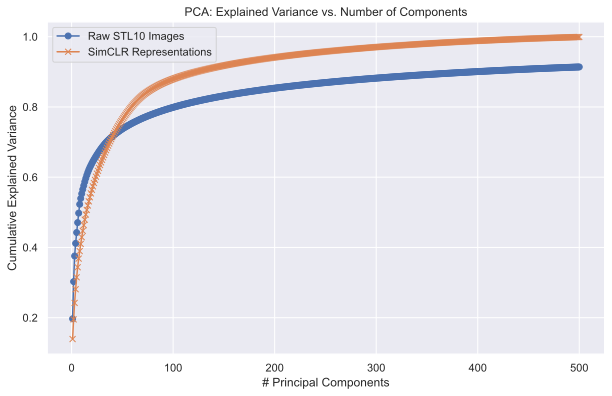

In [ ]:
### Run PCA on the raw STL10 images, and on the corresponding SimCLR representations of those images
num_components = 500

stl10_dataset = STL10(root=DATASET_PATH, split='train', download=True, transform=transforms.ToTensor())

# Prepare the raw STL10 images for PCA
stl10_prepared = prepare_features_stl10_images(stl10_dataset)
stl10_feats, stl10_labels = stl10_prepared.tensors

# Run PCA on the raw STL10 images
pca_stl10 = PCA(n_components=num_components)
pca_stl10.fit(stl10_feats.numpy())
explained_variance_stl10 = pca_stl10.explained_variance_ratio_
cumulative_variance_stl10 = np.cumsum(explained_variance_stl10)

# Extract SimCLR representations for the same images; prepare representations for PCA
simclr_prepared = prepare_features_simclr_representations(model, stl10_dataset)
simclr_feats, simclr_labels = simclr_prepared.tensors

print("First 10 labels in STL10 features:", stl10_labels[:10])
print("First 10 labels in SimCLR features:", stl10_labels[:10])

# Run PCA on the SimCLR representations
pca_simclr = PCA(n_components=num_components)
pca_simclr.fit(simclr_feats.numpy())
explained_variance_simclr = pca_simclr.explained_variance_ratio_
cumulative_variance_simclr = np.cumsum(explained_variance_simclr)

# Plot results
plot_components = range(1, num_components + 1)
plt.figure(figsize=(10, 6))
plt.plot(plot_components, cumulative_variance_stl10, label="Raw STL10 Images", marker='o')
plt.plot(plot_components, cumulative_variance_simclr, label="SimCLR Representations", marker='x')

plt.xlabel("# Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.legend()
plt.grid(True)
plt.show()

Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../models/tutorial17/SimCLR.ckpt`


  0%|          | 0/79 [00:00<?, ?it/s]

Layer 1 features shape: torch.Size([5000, 36864])
Layer 2 features shape: torch.Size([5000, 18432])
Layer 4 features shape: torch.Size([5000, 4608])
Final Layer features shape: torch.Size([5000, 512])


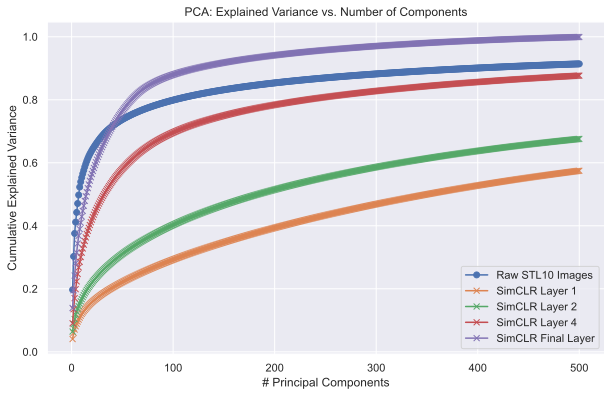

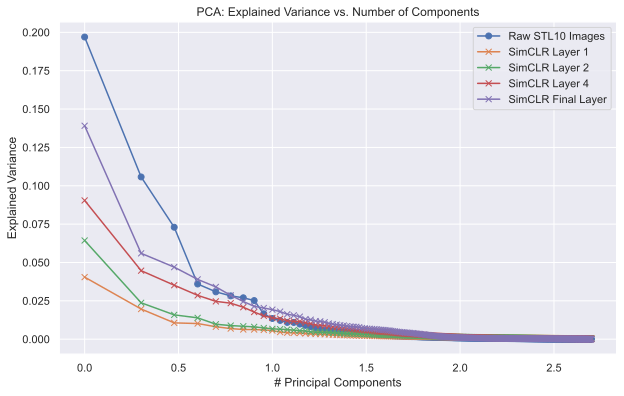

In [ ]:
### Let's try PCA on earlier layers of the base encoder from the SimCLR mode

class SimCLRWithIntermediateLayerOutputs(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

# Function to register hooks and capture outputs from intermediate layers
def register_hooks(model, layers):
    features = {}

    def hook(module, input, output, layer_name):
        features[layer_name] = output.detach()

    for layer_name in layers:
        layer = dict([*model.named_modules()])[layer_name]
        layer.register_forward_hook(lambda module, input, output, layer_name=layer_name: hook(module, input, output, layer_name))
    
    return features

# Modified function to prepare features with intermediate layer outputs
@torch.no_grad()
def prepare_features_simclr_representations_multi_layer(model, dataset, layers_to_capture):
    # Prepare model and register hooks
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Register hooks to capture specific intermediate layers
    features = register_hooks(network, layers_to_capture)
    
    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels, intermediate_features = [], [], {layer: [] for layer in layers_to_capture}
    
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
        
        # Collect intermediate layer outputs
        for layer in layers_to_capture:
            # Final linear layer outputs a 2d tensor; but intermediate layers don't, so we flatten them ready for PCA 
            layer_output_flattened = features[layer].view(features[layer].size(0), -1) 
            intermediate_features[layer].append(layer_output_flattened.cpu())
    
    # Concatenate results for each layer
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    intermediate_features = {layer: torch.cat(intermediate_features[layer], dim=0) for layer in layers_to_capture}
    
    return data.TensorDataset(feats, labels), intermediate_features

# Load the pretrained SimCLR model
model = SimCLRWithIntermediateLayerOutputs.load_from_checkpoint(MODEL_CHECKPOINT_PATH)
model.eval()

layers_to_capture = ['layer1', 'layer2', 'layer3', 'layer4']

# Extract SimCLR representations and intermediate features
simclr_prepared, intermediate_features = prepare_features_simclr_representations_multi_layer(model, stl10_dataset, layers_to_capture)
simclr_feats, simclr_labels = simclr_prepared.tensors
layer1_feats = intermediate_features['layer1']
layer2_feats = intermediate_features['layer2']
layer4_feats = intermediate_features['layer4']

# Layer 1 features shape:     torch.Size([5000, 36864])
# Layer 2 features shape:     torch.Size([5000, 18432])
# Layer 4 features shape:     torch.Size([5000, 4608])])
# Final Layer features shape: torch.Size([5000, 512]
print("Layer 1 features shape:", layer1_feats.shape) 
print("Layer 2 features shape:", layer2_feats.shape) 
print("Layer 4 features shape:", layer4_feats.shape)
print("Final Layer features shape:", simclr_feats.shape)

num_components = 500

# Run PCA on the SimCLR layer 1
pca_simclr_layer1 = PCA(n_components=num_components)
pca_simclr_layer1.fit(layer1_feats.numpy())
explained_variance_simclr_layer1 = pca_simclr_layer1.explained_variance_ratio_
cumulative_variance_simclr_layer1 = np.cumsum(explained_variance_simclr_layer1)

# Run PCA on the SimCLR layer 2
pca_simclr_layer2 = PCA(n_components=num_components)
pca_simclr_layer2.fit(layer2_feats.numpy())
explained_variance_simclr_layer2 = pca_simclr_layer2.explained_variance_ratio_
cumulative_variance_simclr_layer2 = np.cumsum(explained_variance_simclr_layer2)

# Run PCA on the SimCLR layer 4
pca_simclr_layer4 = PCA(n_components=num_components)
pca_simclr_layer4.fit(layer4_feats.numpy())
explained_variance_simclr_layer4 = pca_simclr_layer4.explained_variance_ratio_
cumulative_variance_simclr_layer4 = np.cumsum(explained_variance_simclr_layer4)

# Run PCA on final linear layer
pca_simclr = PCA(n_components=num_components)
pca_simclr.fit(simclr_feats.numpy())
explained_variance_simclr = pca_simclr.explained_variance_ratio_
cumulative_variance_simclr = np.cumsum(explained_variance_simclr)

# Plot cumulative explained variance against number of principal components
plot_components = range(1, num_components + 1)
plt.figure(figsize=(10, 6))
plt.plot(plot_components, cumulative_variance_stl10, label="Raw STL10 Images", marker='o')
plt.plot(plot_components, cumulative_variance_simclr_layer1, label="SimCLR Layer 1", marker='x')
plt.plot(plot_components, cumulative_variance_simclr_layer2, label="SimCLR Layer 2", marker='x')
plt.plot(plot_components, cumulative_variance_simclr_layer4, label="SimCLR Layer 4", marker='x')
plt.plot(plot_components, cumulative_variance_simclr, label="SimCLR Final Layer", marker='x')

plt.xlabel("# Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.legend()
plt.grid(True)
plt.show()

# Plot explained variance (log) against number of principal components (log)
plot_components = np.log10(range(1, num_components + 1))
plt.figure(figsize=(10, 6))
plt.plot(plot_components, np.log10(explained_variance_stl10), label="Raw STL10 Images", marker='o')
plt.plot(plot_components, np.log10(explained_variance_simclr_layer1), label="SimCLR Layer 1", marker='x')
plt.plot(plot_components, np.log10(explained_variance_simclr_layer2), label="SimCLR Layer 2", marker='x')
plt.plot(plot_components, np.log10(explained_variance_simclr_layer4), label="SimCLR Layer 4", marker='x')
plt.plot(plot_components, np.log10(explained_variance_simclr), label="SimCLR Final Layer", marker='x')

plt.xlabel("# Principal Components")
plt.ylabel("Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.legend()
plt.grid(True)
plt.show()

### The initial PCs for the raw images capture a lot of simple pixel-level variance - raw images explain more variance vs. SimCLR final layer
### After a certain number of PCs (~40), SimCLR explains a higher level of the variance vs. the raw images
### For SimCLR, each principal component captures more complex, high-level features (more meaningful variance rather than noise)